In [1]:
from symred.projection import S3_projection, unitary_partitioning_rotations, CS_VQE, CS_VQE_LW
from symred.symplectic import *
from scipy.optimize import shgo, differential_evolution
from symred.utils import gf2_gaus_elim, unit_n_sphere_cartesian_coords
from functools import reduce
import json

In [2]:
with open('data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2-_STO-3G_SINGLET', 'BH3_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3NHCH3_STO-3G_SINGLET', 'CH3CH2NH2_STO-3G_SINGLET', 'CH3CH2OH_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3

In [3]:
from symred.chem import geometry_from_pubchem

# Set molecule parameters
speciesname = 'CO2_STO-3G_SINGLET'
mol_data = molecule_geometries[speciesname]
if 'name' in mol_data:
    print(mol_data['name'])
    
atoms = mol_data['atoms']
coords = mol_data['coords']
basis = mol_data['basis']
multiplicity = mol_data['multiplicity']
charge = mol_data['charge']
geometry = list(zip(atoms, coords))

#geometry = geometry_from_pubchem('N2')

xyz_file = str(len(atoms))+'\n '

for atom, coords in geometry:
    xyz_file += '\n'+atom+'\t'
    xyz_file += '\t'.join(list(map(str, coords)))

print('Molecule geometry:')
print(xyz_file[4:])

carbon dioxide
Molecule geometry:
C	0.0	0.0	0.0
O	0.0	0.0	1.1621
O	0.0	0.0	-1.1621


In [4]:
from symred.chem import PySCFDriver

convergence = 1e6; max_hf_cycles=100_000; ram = 8_000
run_mp2  = True; run_cisd = False; run_ccsd = True; run_fci  = True

pyscf_obj = PySCFDriver(xyz_file,
                        basis,
                        #convergence=convergence,
                        charge=charge,
                        #max_ram_memory=ram,
                        #max_hf_cycles=max_hf_cycles,                   
                        run_mp2=run_mp2,
                        run_cisd=run_cisd,
                        run_ccsd=run_ccsd,
                        run_fci=run_fci)

pyscf_obj.run_pyscf()

print('HF converged?  ', pyscf_obj.pyscf_hf.converged)
print('CCSD converged?', pyscf_obj.pyscf_ccsd.converged)
print('FCI converged? ', pyscf_obj.pyscf_fci.converged)

hf_energy = pyscf_obj.pyscf_hf.e_tot
mp2_energy = pyscf_obj.pyscf_mp2.e_tot
ccsd_energy = pyscf_obj.pyscf_ccsd.e_tot
fci_energy = pyscf_obj.pyscf_fci.e_tot

print()
print(f'HF energy: {hf_energy}')
print(f'MP2 energy: {mp2_energy}')
print(f'CCSD energy: {ccsd_energy}')
print(f'FCI energy: {fci_energy}')

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy: -185.06524523042353
MP2 energy: -185.26547775236608
CCSD energy: -185.2570088866539
FCI energy: -185.27741612068021


In [5]:
from symred.chem import FermionicHamilt, FermioniCC
from openfermion import get_fermion_operator, jordan_wigner, hermitian_conjugated

H_fermion = FermionicHamilt(pyscf_obj.pyscf_hf)
T_fermion = FermioniCC(pyscf_obj.pyscf_ccsd)
H_fermion.build_operator()
T_fermion.build_operator()

n_qubits = H_fermion.n_qubits
print('Number of qubits:', n_qubits)

H = get_fermion_operator(H_fermion.fermionic_molecular_hamiltonian)
T = T_fermion.fermionic_cc_operator
T -= hermitian_conjugated(T)

H_jw = jordan_wigner(H)
T_jw = jordan_wigner(T)

Number of qubits: 30


In [6]:
from openfermion import QubitOperator

def QubitOperator_to_dict(op, num_qubits):
    assert(type(op) == QubitOperator)
    op_dict = {}
    term_dict = op.terms
    terms = list(term_dict.keys())

    for t in terms:    
        letters = ['I' for i in range(num_qubits)]
        for i in t:
            letters[i[0]] = i[1]
        p_string = ''.join(letters)        
        op_dict[p_string] = term_dict[t]
         
    return op_dict

H_q = PauliwordOp(QubitOperator_to_dict(H_jw, n_qubits))
T_q = PauliwordOp(QubitOperator_to_dict(T_jw, n_qubits))
T_q.coeff_vec = T_q.coeff_vec.imag

In [7]:
from symred.projection import QubitTapering

taper_hamiltonian = QubitTapering(H_q)

print(f'We are able to taper {taper_hamiltonian.n_taper} qubits from the Hamiltonian.\n')
print('The symmetry generators are\n')
print(taper_hamiltonian.symmetry_generators)
print('\nand are rotated onto the single-qubit Pauli operators\n')
print(taper_hamiltonian.stabilizers.rotate_onto_single_qubit_paulis())
print('\nvia a sequence of Clifford pi/2 rotations\n')
print(taper_hamiltonian.stabilizers.stabilizer_rotations)

We are able to taper 4 qubits from the Hamiltonian.

The symmetry generators are

1.0000000000+0.0000000000j ZIIZIZIZZIIZIZIZZIZIZIIZIZIZZI +
1.0000000000+0.0000000000j IZIZIZIZIZIZIZIZIZIZIZIZIZIZIZ +
1.0000000000+0.0000000000j IIZZZZZZIIZZIIIIIIZZZZIIIIZZII +
1.0000000000+0.0000000000j IIIIIIIIIIIIZZZZIIZZZZZZZZIIII

and are rotated onto the single-qubit Pauli operators

-1.0000000000+0.0000000000j XIIIIIIIIIIIIIIIIIIIIIIIIIIIII +
-1.0000000000+0.0000000000j IXIIIIIIIIIIIIIIIIIIIIIIIIIIII +
-1.0000000000+0.0000000000j IIXIIIIIIIIIIIIIIIIIIIIIIIIIII +
-1.0000000000+0.0000000000j IIIIIIIIIIIIXIIIIIIIIIIIIIIIII

via a sequence of Clifford pi/2 rotations

[('IIIIIIIIIIIIYZZZIIZZZZZZZZIIII', None), ('IIYZZZZZIIZZIIIIIIZZZZIIIIZZII', None), ('YIIZIZIZZIIZIZIZZIZIZIIZIZIZZI', None), ('IYIZIZIZIZIZIZIZIZIZIZIZIZIZIZ', None)]


In [8]:
hf_array = H_fermion.hf_comp_basis_state
taper_hamiltonian.stabilizers.update_sector(hf_array)
print(f'The symmetry sector corresponding with the single reference {hf_array} is {taper_hamiltonian.stabilizers.coeff_vec}')

The symmetry sector corresponding with the single reference [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0] is [-1 -1  1  1]


In [9]:
ham_tap = taper_hamiltonian.taper_it(ref_state=hf_array)
#sor_tap = taper_hamiltonian.taper_it(aux_operator=sor_ham, ref_state=hf_array)
#sor_tap.coeff_vec/=np.linalg.norm(sor_tap.coeff_vec)
ucc_tap = taper_hamiltonian.taper_it(aux_operator=T_q, ref_state=hf_array)
n_taper = taper_hamiltonian.n_taper
tapered_qubits   = taper_hamiltonian.stab_qubit_indices
untapered_qubits = taper_hamiltonian.free_qubit_indices
hf_tapered = taper_hamiltonian.tapered_ref_state

dashes = "------------------------------------------------"
print("Tapering information:")
print(dashes)
print(f'We are able to taper {taper_hamiltonian.n_taper} qubits from the Hamiltonian')
print('The symmetry basis/sector is:') 
print(taper_hamiltonian.symmetry_generators)
print(f'The tapered Hartree-Fock state is', QuantumState([hf_tapered]))
print(dashes)

Tapering information:
------------------------------------------------
We are able to taper 4 qubits from the Hamiltonian
The symmetry basis/sector is:
-1.0000000000 ZIIZIZIZZIIZIZIZZIZIZIIZIZIZZI +
-1.0000000000 IZIZIZIZIZIZIZIZIZIZIZIZIZIZIZ +
1.0000000000 IIZZZZZZIIZZIIIIIIZZZZIIIIZZII +
1.0000000000 IIIIIIIIIIIIZZZZIIZZZZZZZZIIII
The tapered Hartree-Fock state is  1.0000000000 |11111111111111111100000000>
------------------------------------------------


In [10]:
cs_vqe = CS_VQE(ham_tap, hf_tapered, noncontextual_form = 'diag', basis_weighting_operator=ucc_tap)
cs_vqe_lw = CS_VQE_LW(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap)

In [11]:
print(cs_vqe.clique_operator)

In [12]:
from symred.utils import *

ucc_sort = ucc_tap.sort(key='magnitude')
ham_sort = ham_tap.sort(key='magnitude')

def stabilizers_by_ucc_term_significance(n_terms):
    preserve = ucc_sort[:n_terms]
    ZX_symp = np.hstack([preserve.Z_block, preserve.X_block])
    reduced = gf2_gaus_elim(ZX_symp)
    kernel  = gf2_basis_for_gf2_rref(reduced)
    stabilizers = StabilizerOp(kernel, np.ones(kernel.shape[0]))
    mask_diag = np.where(~np.any(stabilizers.X_block, axis=1))[0]
    return StabilizerOp(stabilizers.symp_matrix[mask_diag], stabilizers.coeff_vec[mask_diag])

def find_stabilizers(n_sim_qubits, region=[0,ucc_sort.n_terms]):
    assert(n_sim_qubits < ham_tap.n_qubits), 'Number of qubits to simulate exceeds those in the operator'
    assert(region[1]-region[0]>1), 'Search region collapsed without identifying any stabilizers'
    
    n_terms = sum(region)//2
    stabilizers = stabilizers_by_ucc_term_significance(n_terms)
    current_n_qubits = ham_tap.n_qubits - stabilizers.n_terms
    sign = np.sign(current_n_qubits - n_sim_qubits)
    
    if sign==0:
        # i.e. n_sim_qubits == current_n_qubits
        return stabilizers
    elif sign==+1:
        # i.e. n_sim_qubits < current_n_qubits
        region[1] = n_terms
    else:
        region[0] = n_terms
    return find_stabilizers(n_sim_qubits, region)

In [26]:
stabilizers = find_stabilizers(5, region=[0,ucc_sort.n_terms])
stab_score = cs_vqe.basis_score(stabilizers)
print('Basis score (min:0, max:1):', stab_score)
ref_energy = fci_energy
ham_cs = cs_vqe.project_onto_subspace(stabilizers, enforce_clique_operator=False)
print(f'Number of qubits in contextual subspace: {ham_cs.n_qubits}/{ham_tap.n_qubits}')
matrix = ham_cs.to_sparse_matrix
e = exact_gs_energy(matrix)[0]
print('Error from FCI:', e-ref_energy)

Basis score (min:0, max:1): 0.71102422964281
Number of qubits in contextual subspace: 5/26
Error from FCI: 0.15709615414178302


In [16]:
ref_energy = fci_energy

scores = []
energy = []

for i in range(1, ham_tap.n_qubits):
    try:
        stabilizers =  find_stabilizers(n_sim_qubits=i, region=[0,ucc_sort.n_terms])
        stab_score = cs_vqe.basis_score(stabilizers)
        scores.append(stab_score)
        print('Basis score (min:0, max:1):', stab_score)
        if i<=16:
            ham_cs = cs_vqe.project_onto_subspace(stabilizers)
            print(f'Number of qubits in contextual subspace: {ham_cs.n_qubits}/{ham_tap.n_qubits}')
            matrix = ham_cs.to_sparse_matrix
            e = exact_gs_energy(matrix)[0]
            print('Error from CCSD:', e-ref_energy)
            energy.append(e)
    except:
        print(i, 'did not work')

Basis score (min:0, max:1): 0.30290860533312636
Number of qubits in contextual subspace: 1/26
Error from CCSD: 0.21217089025680025
Basis score (min:0, max:1): 0.45717606564035
Number of qubits in contextual subspace: 2/26
Error from CCSD: 0.20054917675312822
Basis score (min:0, max:1): 0.5629429615629402
Number of qubits in contextual subspace: 3/26
Error from CCSD: 0.19175868905293214
Basis score (min:0, max:1): 0.6710456836734652
Number of qubits in contextual subspace: 4/26
Error from CCSD: 0.17549841685456613
Basis score (min:0, max:1): 0.71102422964281
Number of qubits in contextual subspace: 5/26
Error from CCSD: 0.15709615414178302
Basis score (min:0, max:1): 0.7488715515370539
Number of qubits in contextual subspace: 6/26
Error from CCSD: 0.14027288325772247
Basis score (min:0, max:1): 0.8182641843879287
Number of qubits in contextual subspace: 7/26
Error from CCSD: 0.10361310432770665
Basis score (min:0, max:1): 0.8297863487772661
Number of qubits in contextual subspace: 8/26


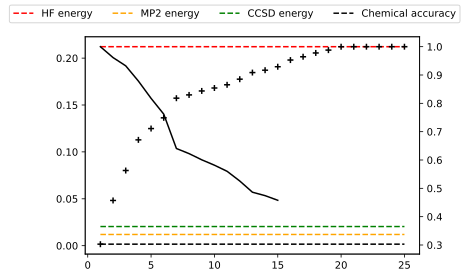

In [18]:
from matplotlib import pyplot as plt
#plt.style.use('ggplot')

fig,energy_axis = plt.subplots()
X=np.arange(1, ham_tap.n_qubits)

Y_energy=np.array(energy)-ref_energy
energy_axis.plot(X[:15], Y_energy, color='black')
energy_axis.hlines(hf_energy-ref_energy, 1, X[-1], ls='--', color='red', label='HF energy')
energy_axis.hlines(mp2_energy-ref_energy, 1, X[-1], ls='--', color='orange', label='MP2 energy')
energy_axis.hlines(ccsd_energy-ref_energy, 1, X[-1], ls='--', color='green', label='CCSD energy')
energy_axis.hlines(0.0016, 1, X[-1], ls='--', color='black', label='Chemical accuracy')

#energy_axis.set_ylim(1e-15, 1e-0) 
#energy_axis.set_yscale('log')

score_axis = energy_axis.twinx()
Y_scores=np.array(scores)
score_axis.scatter(X, Y_scores, color='black', marker='+')

#energy_axis.set_xticks(X)

fig.legend(ncol=4)
plt.show()

In [20]:
from symred.utils import gf2_basis_for_gf2_rref

ucc_sort = op.sort(key='magnitude') #ucc_tap.sort(key='magnitude')

#significant_terms = [cs_vqe.clique_operator[1]]

def stabilizers_by_ucc_term_significance(n_terms):
    preserve = ucc_sort[:n_terms]# + cs_vqe.clique_operator[1]
    ZX_symp = np.hstack([preserve.Z_block, preserve.X_block])
    reduced = gf2_gaus_elim(ZX_symp)
    kernel  = gf2_basis_for_gf2_rref(reduced)
    stabilizers = StabilizerOp(kernel, np.ones(kernel.shape[0]))
    mask_diag = np.where(~np.any(stabilizers.X_block, axis=1))[0]
    return StabilizerOp(stabilizers.symp_matrix[mask_diag], stabilizers.coeff_vec[mask_diag])

def find_stabilizers(n_sim_qubits, region = [0, ucc_sort.n_terms]):
    assert(len(set(region))!=1), 'Search region collapsed without identifying any stabilizers'
    n_terms = sum(region)//2
    stabilizers = stabilizers_by_ucc_term_significance(n_terms)
    current_n_qubits = ucc_sort.n_qubits - stabilizers.n_terms
    sign = np.sign(current_n_qubits - n_sim_qubits)
    
    if sign==0:
        # i.e. n_sim_qubits == current_n_qubits
        return stabilizers
    elif sign==+1:
        # i.e. n_sim_qubits < current_n_qubits
        region[1] = n_terms
    else:
        region[0] = n_terms
    return find_stabilizers(n_sim_qubits, region)
    
stabilizers =  find_stabilizers(n_sim_qubits=3)
print(stabilizers)

NameError: name 'op' is not defined

In [ ]:
cs_vqe.clique_operator = PauliwordOp(['IIYI', 'ZZZI', 'XYXI'], [1,1,1])
cs_vqe.solve_noncontextual()

In [ ]:
print(cs_vqe.clique_operator)

In [ ]:
C = cs_vqe.clique_operator.sort(key='magnitude')
print(C)
print()
UP_rot = unitary_partitioning_rotations(C)
print(C.recursive_rotate_by_Pword(UP_rot).cleanup_zeros())

In [ ]:
print('Basis score (min:0, max:1):', cs_vqe.basis_score(stabilizers))
ham_cs = cs_vqe.contextual_subspace_projection([C, stabilizers[0]])
print('Number of qubits in contextual subspace:', ham_cs.n_qubits)

In [ ]:
from symred.utils import exact_gs_energy

exact_gs_energy(ham_cs.to_sparse_matrix)[0] - energy

In [ ]:
ham_cs.n_terms

In [ ]:
cs_vqe_lw = CS_VQE_LW(op, ref_state=[1,1,1,1])
stab = PauliwordOp(['ZZZI', 'IIIZ'],[1,1])

In [ ]:
ham_cs_2 = cs_vqe_lw.project_onto_subspace(stab)
exact_gs_energy(ham_cs_2.to_sparse_matrix)[0] - energy

In [ ]:
ham_cs_2.n_terms

In [ ]:
from symred.symplectic_form import ObservableGraph
from symred.utils import gf2_basis_for_gf2_rref

HamGraph = ObservableGraph(ucc_tap.symp_matrix, ucc_tap.coeff_vec)
QWC_operators = HamGraph.clique_cover(clique_relation='QWC', colouring_strategy='largest_first')
ucc_norm = np.linalg.norm(ucc_tap.coeff_vec)
significant_QWC_groups = [op for op in QWC_operators.values() if np.linalg.norm(op.coeff_vec)>ucc_norm/10]
for op in significant_QWC_groups:
    print(op)
    ZX_symp = np.hstack([op.Z_block, op.X_block])
    reduced = gf2_gaus_elim(ZX_symp)
    kernel  = gf2_basis_for_gf2_rref(reduced)
    stabilizers = StabilizerOp(kernel, np.ones(kernel.shape[0]))
    mask_diag = np.where(~np.any(stabilizers.X_block, axis=1))[0]
    stabilizers = StabilizerOp(stabilizers.symp_matrix[mask_diag], stabilizers.coeff_vec[mask_diag])
    print(stabilizers)
    print()

In [ ]:
ham_tap.n_qubits

In [ ]:
random_stabs = []
n_stabs = 3
for i in range(10000):
    random_Z_block = np.random.randint(0,2,(n_stabs,ham_tap.n_qubits))
    symp_matrix = np.hstack([np.zeros_like(random_Z_block), random_Z_block])
    try:
        basis = StabilizerOp(symp_matrix, np.ones(n_stabs))
        random_stabs.append([cs_vqe.basis_score(basis), basis])
    except:
        pass
    
score, stabs = sorted(random_stabs,key = lambda x:-x[0])[0]
stabs = [stabs[i] for i in range(stabs.n_terms)]
ham_cs = cs_vqe.contextual_subspace_projection(stabs)

print(score)
print(stabs)
exact_gs_energy(ham_cs.to_sparse_matrix)[0] - fci_energy

In [ ]:
ham_tap

In [ ]:
print(cs_vqe.basis_weighting_operator)